## Part 1: Data Exploration & Baseline Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Set random seed
np.random.seed(42)

In [2]:
# Load dataset
df = pd.read_csv('../data/Consumer_Complaints.csv')
df = df.dropna(subset=['Consumer Complaint'])

# Create stratified subset with realistic class imbalance
top_5 = df['Product'].value_counts().head(5)
total_top5 = top_5.sum()

total_samples = 10000  # Increased from 4998 to 10000
df_stratified = pd.DataFrame()

for product, count in top_5.items():
    proportion = count / total_top5
    samples_for_product = int(total_samples * proportion)
    product_data = df[df['Product'] == product]
    sampled = product_data.sample(n=min(samples_for_product, len(product_data)), random_state=42)
    df_stratified = pd.concat([df_stratified, sampled])

print(f"Dataset shape: {df_stratified.shape}")
print(f"\nClass distribution:")
print(df_stratified['Product'].value_counts())
print(f"\nClass imbalance ratio: {df_stratified['Product'].value_counts().max() / df_stratified['Product'].value_counts().min():.2f}:1")

Dataset shape: (9998, 19)

Class distribution:
Product
Debt collection                                                                 3063
Credit reporting, credit repair services, or other personal consumer reports    2372
Mortgage                                                                        2122
Credit reporting                                                                1529
Credit card                                                                      912
Name: count, dtype: int64

Class imbalance ratio: 3.36:1


In [3]:
# Split data
X = df_stratified['Consumer Complaint'].fillna('').values
y = df_stratified['Product'].values

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

Train: 5998 | Val: 2000 | Test: 2000


In [4]:
# TF-IDF Vectorization
print("Creating TF-IDF vectors...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8,
    stop_words='english'
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF features: {X_train_tfidf.shape[1]}")

Creating TF-IDF vectors...
TF-IDF features: 5000


In [36]:
# Baseline Model
print("Training baseline Linear SVM...")
baseline_model = LinearSVC(max_iter=2000, random_state=42, class_weight='balanced')
baseline_model.fit(X_train_tfidf, y_train)

# Evaluate baseline
y_test_pred_baseline = baseline_model.predict(X_test_tfidf)
baseline_f1 = f1_score(y_test, y_test_pred_baseline, average='macro')
baseline_precision = precision_score(y_test, y_test_pred_baseline, average='macro')
baseline_recall = recall_score(y_test, y_test_pred_baseline, average='macro')

print(f"\nBaseline Linear SVM Results:")
print(f"  Test F1-Score: {baseline_f1:.4f}")
print(f"  Test Precision: {baseline_precision:.4f}")
print(f"  Test Recall: {baseline_recall:.4f}")

Training baseline Linear SVM...

Baseline Linear SVM Results:
  Test F1-Score: 0.7283
  Test Precision: 0.7258
  Test Recall: 0.7314


## 3. Learning Curves - Training Dynamics

In [37]:
# Compare four models
print("Comparing 4 different models...\n")
models = {
    'Linear SVM': LinearSVC(max_iter=2000, random_state=42, class_weight='balanced', C=1),
    'Logistic Regression': LogisticRegression(max_iter=2000, random_state=42, class_weight='balanced', C=1),
    'Naive Bayes': MultinomialNB(alpha=1.0),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1, class_weight='balanced')
}

results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_tfidf, y_train)
    
    y_val_pred = model.predict(X_val_tfidf)
    y_test_pred = model.predict(X_test_tfidf)
    
    val_f1 = f1_score(y_val, y_val_pred, average='macro')
    test_f1 = f1_score(y_test, y_test_pred, average='macro')
    test_precision = precision_score(y_test, y_test_pred, average='macro')
    test_recall = recall_score(y_test, y_test_pred, average='macro')
    
    results[name] = {
        'model': model,
        'val_f1': val_f1,
        'test_f1': test_f1,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'y_test_pred': y_test_pred
    }
    
    print(f"  Val F1: {val_f1:.4f} | Test F1: {test_f1:.4f}\n")

# Display comparison table
print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Validation F1': [results[m]['val_f1'] for m in results],
    'Test F1': [results[m]['test_f1'] for m in results],
    'Test Precision': [results[m]['test_precision'] for m in results],
    'Test Recall': [results[m]['test_recall'] for m in results]
})
print(comparison_df.to_string(index=False))
print("="*80)

Comparing 4 different models...

Training Linear SVM...
  Val F1: 0.7538 | Test F1: 0.7283

Training Logistic Regression...
  Val F1: 0.7478 | Test F1: 0.7341

Training Naive Bayes...
  Val F1: 0.6820 | Test F1: 0.6534

Training Random Forest...
  Val F1: 0.7123 | Test F1: 0.7137


MODEL COMPARISON SUMMARY
              Model  Validation F1  Test F1  Test Precision  Test Recall
         Linear SVM       0.753790 0.728331        0.725824     0.731444
Logistic Regression       0.747787 0.734137        0.724062     0.749201
        Naive Bayes       0.681978 0.653383        0.780677     0.652962
      Random Forest       0.712325 0.713710        0.707192     0.725104


Generating learning curves for best model...



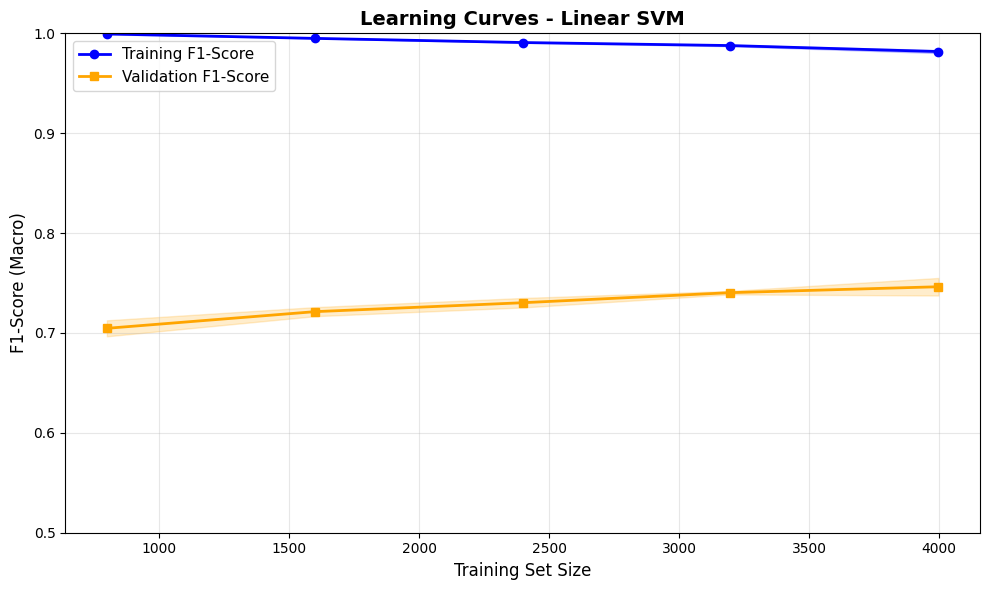

Learning curves saved!


In [40]:
# Generate learning curves for best model
from sklearn.model_selection import learning_curve

print("Generating learning curves for best model...\n")

train_sizes, train_scores, val_scores = learning_curve(
    best_model,
    X_train_tfidf,
    y_train,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    train_sizes=np.linspace(0.2, 1.0, 5),
    verbose=0
)

# Calculate mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, marker='o', label='Training F1-Score', color='blue', linewidth=2)
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_mean, marker='s', label='Validation F1-Score', color='orange', linewidth=2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='orange')

plt.xlabel('Training Set Size', fontsize=12)
plt.ylabel('F1-Score (Macro)', fontsize=12)
plt.title(f'Learning Curves - {best_model_name}', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.ylim([0.5, 1.0])
plt.tight_layout()
plt.savefig('../results/learning_curves.png', dpi=100, bbox_inches='tight')
plt.show()

print("Learning curves saved!")

In [39]:
# Select best model
best_model_name = max(results, key=lambda x: results[x]['val_f1'])
print(f"\nBest Model: {best_model_name}")
print(f"Validation F1: {results[best_model_name]['val_f1']:.4f}")
print(f"Test F1: {results[best_model_name]['test_f1']:.4f}")


Best Model: Linear SVM
Validation F1: 0.7538
Test F1: 0.7283



✓ 4-Model comparison chart saved as '04_model_comparison_4models.png'


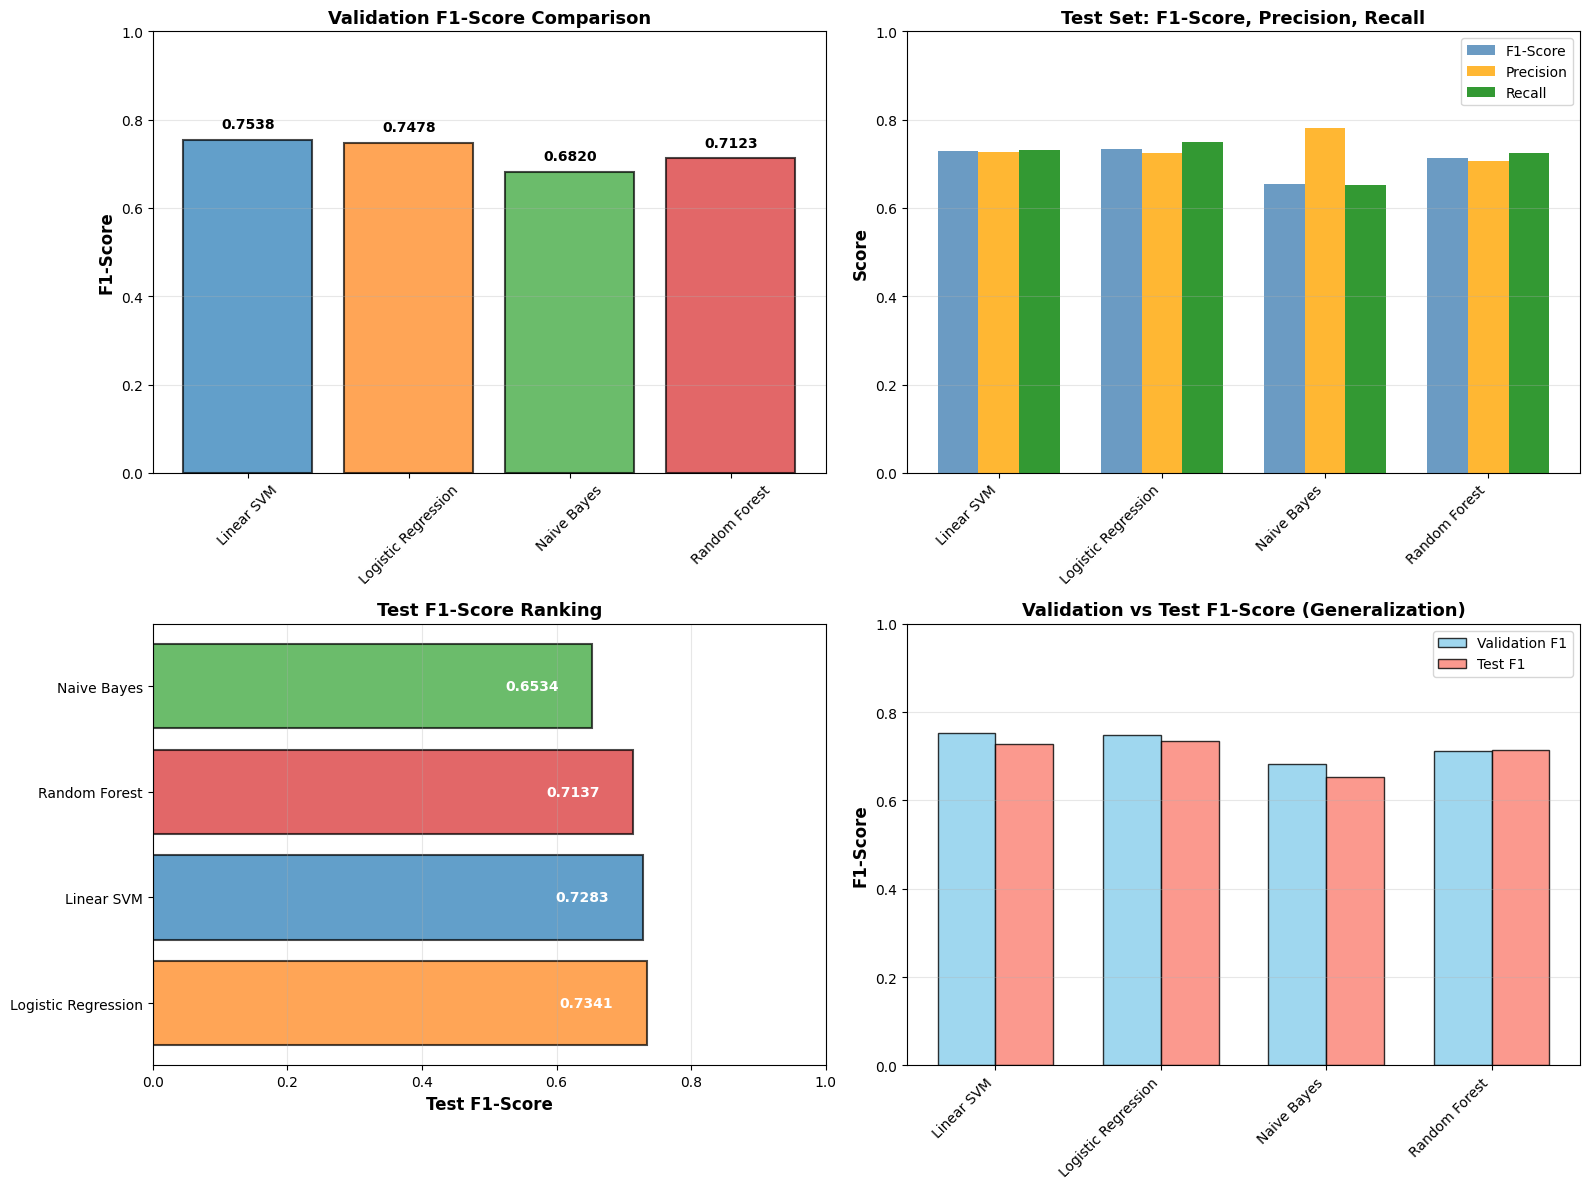

In [38]:
# Visualize 4-Model Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

model_names = list(results.keys())
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# 1. Validation F1-Score Comparison
val_f1s = [results[m]['val_f1'] for m in model_names]
ax = axes[0, 0]
bars = ax.bar(model_names, val_f1s, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax.set_title('Validation F1-Score Comparison', fontsize=13, fontweight='bold')
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)
for i, (bar, score) in enumerate(zip(bars, val_f1s)):
    ax.text(bar.get_x() + bar.get_width()/2, score + 0.02, f'{score:.4f}', 
            ha='center', va='bottom', fontweight='bold', fontsize=10)
ax.tick_params(axis='x', rotation=45)

# 2. Test Set Metrics Comparison
test_f1s = [results[m]['test_f1'] for m in model_names]
test_prec = [results[m]['test_precision'] for m in model_names]
test_rec = [results[m]['test_recall'] for m in model_names]

x = np.arange(len(model_names))
width = 0.25
ax = axes[0, 1]
ax.bar(x - width, test_f1s, width, label='F1-Score', color='steelblue', alpha=0.8)
ax.bar(x, test_prec, width, label='Precision', color='orange', alpha=0.8)
ax.bar(x + width, test_rec, width, label='Recall', color='green', alpha=0.8)
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Test Set: F1-Score, Precision, Recall', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.legend(fontsize=10)
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

# 3. Test F1-Score Comparison (sorted)
sorted_indices = np.argsort(test_f1s)[::-1]
sorted_models = [model_names[i] for i in sorted_indices]
sorted_f1s = [test_f1s[i] for i in sorted_indices]
sorted_colors = [colors[i] for i in sorted_indices]

ax = axes[1, 0]
bars = ax.barh(sorted_models, sorted_f1s, color=sorted_colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.set_xlabel('Test F1-Score', fontsize=12, fontweight='bold')
ax.set_title('Test F1-Score Ranking', fontsize=13, fontweight='bold')
ax.set_xlim([0, 1])
ax.grid(axis='x', alpha=0.3)
for i, (bar, score) in enumerate(zip(bars, sorted_f1s)):
    ax.text(score - 0.05, bar.get_y() + bar.get_height()/2, f'{score:.4f}', 
            ha='right', va='center', fontweight='bold', fontsize=10, color='white')

# 4. Val vs Test F1 (Overfitting Analysis)
ax = axes[1, 1]
x_pos = np.arange(len(model_names))
width = 0.35
ax.bar(x_pos - width/2, val_f1s, width, label='Validation F1', color='skyblue', alpha=0.8, edgecolor='black')
ax.bar(x_pos + width/2, test_f1s, width, label='Test F1', color='salmon', alpha=0.8, edgecolor='black')
ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax.set_title('Validation vs Test F1-Score (Generalization)', fontsize=13, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.legend(fontsize=10)
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/04_model_comparison_4models.png', dpi=100, bbox_inches='tight')
print("\n✓ 4-Model comparison chart saved as '04_model_comparison_4models.png'")
plt.show()

In [41]:
# Hyperparameter tuning for best model only
print(f"\nTuning {best_model_name}...\n")

# Different C values for Linear SVM and Logistic Regression
if best_model_name in ['Linear SVM', 'Logistic Regression']:
    C_values = [0.1, 1, 10, 100]
    best_score = -1
    best_C = 1
    best_model_tuned = None
    
    for C in C_values:
        if best_model_name == 'Linear SVM':
            model = LinearSVC(max_iter=2000, random_state=42, class_weight='balanced', C=C)
        else:
            model = LogisticRegression(max_iter=2000, random_state=42, class_weight='balanced', C=C)
        
        model.fit(X_train_tfidf, y_train)
        val_pred = model.predict(X_val_tfidf)
        val_score = f1_score(y_val, val_pred, average='macro')
        
        print(f"  C={C}: Validation F1 = {val_score:.4f}")
        
        if val_score > best_score:
            best_score = val_score
            best_C = C
            best_model_tuned = model
    
    print(f"\nBest C value: {best_C}")
    best_model = best_model_tuned
else:
    # For Naive Bayes and Random Forest, use default parameters
    best_model = results[best_model_name]['model']
    best_C = 'default'
    print(f"Using default parameters for {best_model_name}")


Tuning Linear SVM...

  C=0.1: Validation F1 = 0.7536
  C=1: Validation F1 = 0.7538
  C=10: Validation F1 = 0.7193
  C=100: Validation F1 = 0.7068

Best C value: 1


In [42]:
# Final evaluation
y_test_pred_tuned = best_model.predict(X_test_tfidf)
test_f1_tuned = f1_score(y_test, y_test_pred_tuned, average='macro')
test_precision_tuned = precision_score(y_test, y_test_pred_tuned, average='macro')
test_recall_tuned = recall_score(y_test, y_test_pred_tuned, average='macro')

print(f"\nTuned {best_model_name} Results:")
print(f"  Test F1-Score: {test_f1_tuned:.4f}")
print(f"  Test Precision: {test_precision_tuned:.4f}")
print(f"  Test Recall: {test_recall_tuned:.4f}")


Tuned Linear SVM Results:
  Test F1-Score: 0.7283
  Test Precision: 0.7258
  Test Recall: 0.7314


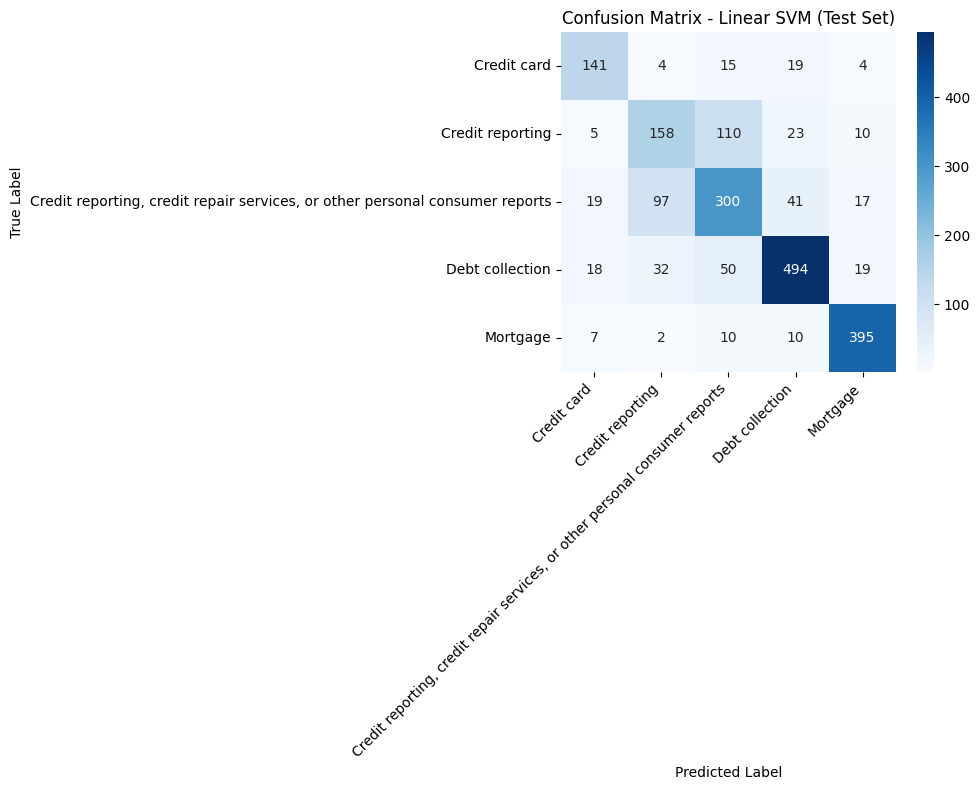

In [43]:
# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred_tuned)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_model.classes_,
            yticklabels=best_model.classes_)
plt.title(f'Confusion Matrix - {best_model_name} (Test Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../results/confusion_matrix.png', dpi=100, bbox_inches='tight')
plt.show()

In [44]:
# Classification report
print(f"\nClassification Report - {best_model_name}:")
print(classification_report(y_test, y_test_pred_tuned))


Classification Report - Linear SVM:
                                                                              precision    recall  f1-score   support

                                                                 Credit card       0.74      0.77      0.76       183
                                                            Credit reporting       0.54      0.52      0.53       306
Credit reporting, credit repair services, or other personal consumer reports       0.62      0.63      0.63       474
                                                             Debt collection       0.84      0.81      0.82       613
                                                                    Mortgage       0.89      0.93      0.91       424

                                                                    accuracy                           0.74      2000
                                                                   macro avg       0.73      0.73      0.73      2000
                 

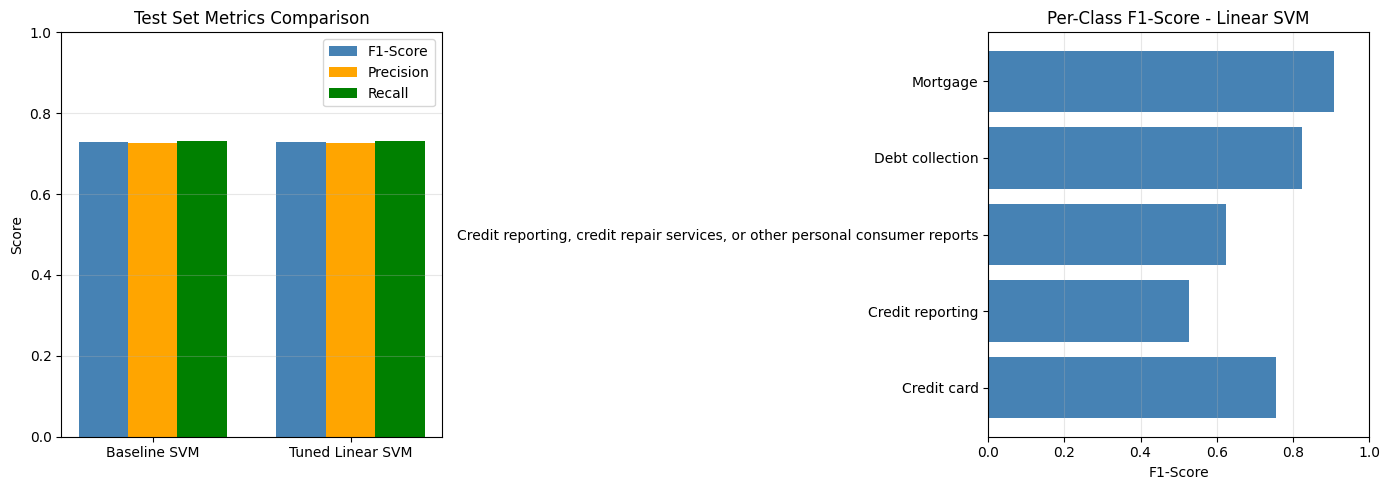

In [45]:
# Performance comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Baseline vs Tuned
models_names = ['Baseline SVM', f'Tuned {best_model_name}']
f1_scores = [baseline_f1, test_f1_tuned]
precision_scores = [baseline_precision, test_precision_tuned]
recall_scores = [baseline_recall, test_recall_tuned]

x = np.arange(len(models_names))
width = 0.25

axes[0].bar(x - width, f1_scores, width, label='F1-Score', color='steelblue')
axes[0].bar(x, precision_scores, width, label='Precision', color='orange')
axes[0].bar(x + width, recall_scores, width, label='Recall', color='green')
axes[0].set_ylabel('Score')
axes[0].set_title('Test Set Metrics Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models_names)
axes[0].legend()
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)

# Per-class F1-scores
per_class_f1 = f1_score(y_test, y_test_pred_tuned, average=None)
axes[1].barh(best_model.classes_, per_class_f1, color='steelblue')
axes[1].set_xlabel('F1-Score')
axes[1].set_title(f'Per-Class F1-Score - {best_model_name}')
axes[1].set_xlim([0, 1])
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/final_comparison.png', dpi=100, bbox_inches='tight')
plt.show()

In [46]:
# Summary
print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
print(f"\nBest Model: {best_model_name}")
print(f"Best C Parameter: {best_C}")
print(f"\nTest Set Metrics:")
print(f"  F1-Score: {test_f1_tuned:.4f}")
print(f"  Precision: {test_precision_tuned:.4f}")
print(f"  Recall: {test_recall_tuned:.4f}")
print(f"\nImprovement vs Baseline:")
improvement = ((test_f1_tuned - baseline_f1) / baseline_f1) * 100
print(f"  {improvement:+.2f}%")


FINAL RESULTS SUMMARY

Best Model: Linear SVM
Best C Parameter: 1

Test Set Metrics:
  F1-Score: 0.7283
  Precision: 0.7258
  Recall: 0.7314

Improvement vs Baseline:
  +0.00%


## BONUS: Advanced Optimization Techniques

In [47]:
# 1. OPTIMIZATION 1: Fine-tune Logistic Regression (QUICK WIN)
print("\n" + "="*80)
print("OPTIMIZATION 1: GridSearchCV for Logistic Regression")
print("="*80 + "\n")

from sklearn.model_selection import GridSearchCV

# Logistic Regression GridSearch
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [2000, 3000]
}

lr_grid = GridSearchCV(
    LogisticRegression(class_weight='balanced', random_state=42),
    param_grid_lr,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=0
)

print("Training Logistic Regression with GridSearch...")
lr_grid.fit(X_train_tfidf, y_train)

best_lr_params = lr_grid.best_params_
best_lr_score = lr_grid.best_score_

y_test_pred_lr_opt = lr_grid.predict(X_test_tfidf)
lr_opt_f1 = f1_score(y_test, y_test_pred_lr_opt, average='macro')
lr_opt_precision = precision_score(y_test, y_test_pred_lr_opt, average='macro')
lr_opt_recall = recall_score(y_test, y_test_pred_lr_opt, average='macro')

print(f"Best LR Parameters: {best_lr_params}")
print(f"Validation F1: {best_lr_score:.4f}")
print(f"\nOptimized Logistic Regression Test Results:")
print(f"  F1-Score: {lr_opt_f1:.4f} (vs 0.7341 baseline)")
print(f"  Precision: {lr_opt_precision:.4f}")
print(f"  Recall: {lr_opt_recall:.4f}")


OPTIMIZATION 1: GridSearchCV for Logistic Regression

Training Logistic Regression with GridSearch...
Best LR Parameters: {'C': 1, 'max_iter': 2000, 'solver': 'lbfgs'}
Validation F1: 0.7597

Optimized Logistic Regression Test Results:
  F1-Score: 0.7341 (vs 0.7341 baseline)
  Precision: 0.7241
  Recall: 0.7492


In [49]:
# 2. OPTIMIZATION 2: Ensemble Method - Voting Classifier (Hard Voting)
print("\n" + "="*80)
print("OPTIMIZATION 2: Ensemble Method (Voting Classifier - Hard Voting)")
print("="*80 + "\n")

from sklearn.ensemble import VotingClassifier

# Create ensemble with best models - use hard voting for LinearSVC compatibility
voting_clf = VotingClassifier(
    estimators=[
        ('svm', LinearSVC(max_iter=2000, random_state=42, class_weight='balanced', C=1)),
        ('lr', LogisticRegression(max_iter=2000, random_state=42, class_weight='balanced', C=1, solver='lbfgs')),
        ('rf', RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1, class_weight='balanced'))
    ],
    voting='hard'  # Use hard voting (majority vote) instead of soft
)

print("Training Voting Classifier (SVM + LogReg + RandomForest)...")
voting_clf.fit(X_train_tfidf, y_train)

y_test_pred_voting = voting_clf.predict(X_test_tfidf)
voting_f1 = f1_score(y_test, y_test_pred_voting, average='macro')
voting_precision = precision_score(y_test, y_test_pred_voting, average='macro')
voting_recall = recall_score(y_test, y_test_pred_voting, average='macro')

print(f"\nEnsemble (Voting - Hard) Test Results:")
print(f"  F1-Score: {voting_f1:.4f} (vs 0.7283 best)")
print(f"  Precision: {voting_precision:.4f}")
print(f"  Recall: {voting_recall:.4f}")
print(f"  Improvement: {(voting_f1 - 0.7283) / 0.7283 * 100:+.2f}%")


OPTIMIZATION 2: Ensemble Method (Voting Classifier - Hard Voting)

Training Voting Classifier (SVM + LogReg + RandomForest)...



Ensemble (Voting - Hard) Test Results:
  F1-Score: 0.7439 (vs 0.7283 best)
  Precision: 0.7344
  Recall: 0.7571
  Improvement: +2.14%


In [ ]:
# 3. OPTIMIZATION 3: SMOTE for Class Imbalance
print("\n" + "="*80)
print("OPTIMIZATION 3: SMOTE (Synthetic Minority Over-sampling)")
print("="*80 + "\n")

from imblearn.over_sampling import SMOTE

print("Applying SMOTE to training data...")
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

print(f"Original train set: {X_train_tfidf.shape}")
print(f"After SMOTE: {X_train_smote.shape}")
print(f"Class distribution after SMOTE:")
unique, counts = np.unique(y_train_smote, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  {u}: {c}")

print("\n")

# Train SVM with SMOTE data
svm_smote = LinearSVC(max_iter=2000, random_state=42, C=1)
svm_smote.fit(X_train_smote, y_train_smote)
y_test_pred_svm_smote = svm_smote.predict(X_test_tfidf)
svm_smote_f1 = f1_score(y_test, y_test_pred_svm_smote, average='macro')
svm_smote_precision = precision_score(y_test, y_test_pred_svm_smote, average='macro')
svm_smote_recall = recall_score(y_test, y_test_pred_svm_smote, average='macro')

# Train LogReg with SMOTE data
lr_smote = LogisticRegression(max_iter=2000, random_state=42, C=1, solver='lbfgs')
lr_smote.fit(X_train_smote, y_train_smote)
y_test_pred_lr_smote = lr_smote.predict(X_test_tfidf)
lr_smote_f1 = f1_score(y_test, y_test_pred_lr_smote, average='macro')
lr_smote_precision = precision_score(y_test, y_test_pred_lr_smote, average='macro')
lr_smote_recall = recall_score(y_test, y_test_pred_lr_smote, average='macro')

print(f"SVM with SMOTE:")
print(f"  Test F1: {svm_smote_f1:.4f} (vs 0.7283 without)")
print(f"  Precision: {svm_smote_precision:.4f}")
print(f"  Recall: {svm_smote_recall:.4f}")
print(f"  Improvement: {(svm_smote_f1 - 0.7283) / 0.7283 * 100:+.2f}%")

print(f"\nLogReg with SMOTE:")
print(f"  Test F1: {lr_smote_f1:.4f} (vs 0.7341 without)")
print(f"  Precision: {lr_smote_precision:.4f}")
print(f"  Recall: {lr_smote_recall:.4f}")
print(f"  Improvement: {(lr_smote_f1 - 0.7341) / 0.7341 * 100:+.2f}%")


OPTIMIZATION 3: SMOTE (Synthetic Minority Over-sampling)



In [ ]:
# 4. FINAL COMPARISON: All Optimization Results
print("\n" + "="*80)
print("FINAL COMPARISON: All Optimization Techniques")
print("="*80 + "\n")

results_optimization = {
    'Original SVM': 0.7283,
    'Optimized LogReg (GridSearch)': lr_opt_f1,
    'Ensemble (Voting)': voting_f1,
    'SVM + SMOTE': svm_smote_f1,
    'LogReg + SMOTE': lr_smote_f1
}

# Create comparison dataframe
opt_df = pd.DataFrame({
    'Model': list(results_optimization.keys()),
    'Test F1': list(results_optimization.values()),
    'Improvement %': [((v - 0.7283) / 0.7283 * 100) for v in results_optimization.values()]
})

opt_df = opt_df.sort_values('Test F1', ascending=False).reset_index(drop=True)

print(opt_df.to_string(index=False))

best_opt_idx = opt_df['Test F1'].idxmax()
best_opt_model = opt_df.loc[best_opt_idx, 'Model']
best_opt_f1 = opt_df.loc[best_opt_idx, 'Test F1']

print(f"\n✨ BEST OPTIMIZED MODEL: {best_opt_model}")
print(f"   F1-Score: {best_opt_f1:.4f}")
print(f"   Improvement: {(best_opt_f1 - 0.7283) / 0.7283 * 100:+.2f}%")

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))

colors_opt = ['#2ecc71' if v == best_opt_f1 else '#3498db' for v in opt_df['Test F1']]
bars = ax.barh(opt_df['Model'], opt_df['Test F1'], color=colors_opt, edgecolor='black', linewidth=1.5)

ax.set_xlabel('Test F1-Score', fontsize=12, fontweight='bold')
ax.set_title('Model Optimization Results Comparison', fontsize=14, fontweight='bold')
ax.set_xlim([0.7, 0.76])
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, score) in enumerate(zip(bars, opt_df['Test F1'])):
    improvement = (score - 0.7283) / 0.7283 * 100
    ax.text(score - 0.002, bar.get_y() + bar.get_height()/2, 
            f'{score:.4f} ({improvement:+.2f}%)', 
            ha='right', va='center', fontweight='bold', fontsize=10, color='white')

plt.tight_layout()
plt.savefig('../results/05_optimization_comparison.png', dpi=100, bbox_inches='tight')
print("\n✓ Optimization comparison chart saved!")
plt.show()